# Investment Planning in PyPSA

This tutorial covers how to perform investment planning in PyPSA, including multi-period optimization, investment costs, and capacity expansion planning.

## Multi-Period Investment Planning

Let's create a network with multiple investment periods to plan capacity expansion over time:

In [31]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create network
network = pypsa.Network()

# Define investment periods
years = [2020, 2030, 2040, 2050]
# Simplify temporal resolution for the tutorial: Weekly average (168 hours)
freq = "168"  # Resolution: one snapshot per week

# Create snapshots for each period
snapshots = pd.DatetimeIndex([])
for year in years:
    # Calculate integer number of periods per year (weeks)
    num_periods = int(8760 / int(freq)) # Should be 52
    period = pd.date_range(
        start=f"{year}-01-01 00:00",
        freq=f"{freq}H", # Weekly frequency
        periods=num_periods
    )
    snapshots = snapshots.append(period)

# Set snapshots and investment periods
network.snapshots = pd.MultiIndex.from_arrays([snapshots.year, snapshots])
network.investment_periods = years

print("Network snapshots:")
print(network.snapshots)
print("\nInvestment periods:")
print(network.investment_periods)

Network snapshots:
MultiIndex([(2020, '2020-01-01'),
            (2020, '2020-01-08'),
            (2020, '2020-01-15'),
            (2020, '2020-01-22'),
            (2020, '2020-01-29'),
            (2020, '2020-02-05'),
            (2020, '2020-02-12'),
            (2020, '2020-02-19'),
            (2020, '2020-02-26'),
            (2020, '2020-03-04'),
            ...
            (2050, '2050-10-22'),
            (2050, '2050-10-29'),
            (2050, '2050-11-05'),
            (2050, '2050-11-12'),
            (2050, '2050-11-19'),
            (2050, '2050-11-26'),
            (2050, '2050-12-03'),
            (2050, '2050-12-10'),
            (2050, '2050-12-17'),
            (2050, '2050-12-24')],
           name='snapshot', length=208)

Investment periods:
Index([2020, 2030, 2040, 2050], dtype='int32', name='period')


C:\Users\User\AppData\Local\Temp\ipykernel_20888\2483654109.py:19: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



## Setting Up Investment Weightings

We need to set up investment period weightings to account for the time value of money:

In [32]:
# Set investment period weightings
r = 0.01  # Social discount rate
T = 0

# First, set the years for each investment period
# Assuming 10-year periods between each investment year
network.investment_period_weightings["years"] = {
    2020: 10,  # 2020-2030
    2030: 10,  # 2030-2040
    2040: 10,  # 2040-2050
    2050: 10   # 2050-2060
}

# Calculate objective function weightings based on discount rate
for period, nyears in network.investment_period_weightings.years.items():
    discounts = [(1 / (1 + r) ** t) for t in range(T, T + int(nyears))]
    network.investment_period_weightings.at[period, "objective"] = sum(discounts)
    T += int(nyears)

print("Investment period weightings:")
print(network.investment_period_weightings)

Investment period weightings:
        objective  years
period                  
2020     9.566018     10
2030     8.659991     10
2040     7.839777     10
2050     7.097248     10


## Adding Network Components

Let's add components with investment options:

In [33]:
def repeat_daily_profile(snapshots, daily_values):
    """Repeats a daily profile (list of 24 values) across all snapshots."""
    profile_list = []
    num_snapshots = len(snapshots)
    if len(daily_values) != 24:
        # Adapt function if base profile is not daily, for now assume daily base
        raise ValueError("daily_values must have length 24 for this implementation")
    
    # Calculate how many full days and remaining hours are in snapshots
    num_days = num_snapshots // 24
    remaining_hours = num_snapshots % 24
    
    # Repeat the daily profile for the full days
    profile_list = daily_values * num_days
    
    # Add the remaining hours
    if remaining_hours > 0:
        profile_list.extend(daily_values[:remaining_hours])
    
    # Check if length matches (important due to simplified weekly averaging)
    # This simple repeat might not be fully representative for weekly averages,
    # but serves for demonstrating the structure.
    if len(profile_list) != num_snapshots:
        # Adjust length if needed, e.g., by repeating last value or truncating
        # For simplicity, we might truncate or pad, but check logic carefully.
        # Let's pad with the first value if too short, or truncate if too long.
        if len(profile_list) < num_snapshots:
            profile_list.extend([daily_values[0]] * (num_snapshots - len(profile_list)))
        else:
            profile_list = profile_list[:num_snapshots]
            
    return pd.Series(profile_list, index=snapshots)

In [34]:
# Add buses
for i in range(3):
    network.add("Bus", f"bus {i}")

# Add carriers
network.add("Carrier", "gas", co2_emissions=0.2)
network.add("Carrier", "solar")
network.add("Carrier", "wind")

# Add generators with investment options
network.add(
    "Generator",
    "gas_plant",
    bus="bus 0",
    p_nom=0,  # Start with zero capacity
    p_nom_extendable=True,  # Allow capacity expansion
    p_nom_min=0,  # Minimum capacity
    p_nom_max=1000,  # Maximum capacity
    marginal_cost=50, # Illustrative EUR/MWh
    capital_cost=1000, # Illustrative EUR/MW
    carrier="gas",
    efficiency=0.4
)

# Create a solar profile for each snapshot in the network
base_solar_profile = [0.0, 0.0, 0.0, 0.0, 0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 0.9, 0.8,
                      0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0]

# Use helper function to create the full profile
solar_profile = repeat_daily_profile(network.snapshots, base_solar_profile)

network.add(
    "Generator",
    "solar",
    bus="bus 1",
    p_nom=0,
    p_nom_extendable=True,
    p_nom_min=0,
    p_nom_max=1000,
    p_max_pu=solar_profile,
    marginal_cost=0, # Illustrative EUR/MWh
    capital_cost=800, # Illustrative EUR/MW
    carrier="solar"
)

# Add load with growth
base_load_profile = [0.6, 0.5, 0.4, 0.4, 0.5, 0.7, 0.8, 0.9, 0.9, 0.8, 0.7, 0.7,
                     0.7, 0.7, 0.7, 0.7, 0.8, 0.9, 0.9, 0.8, 0.7, 0.6, 0.5, 0.5]

# Use helper function to create the full profile
load_profile = repeat_daily_profile(network.snapshots, base_load_profile)

# Apply growth factor based on the year (level 0 of MultiIndex)
growth_factor = (1 + 0.02 * (network.snapshots.get_level_values(0) - 2020))

network.add(
    "Load",
    "load",
    bus="bus 2",
    p_set=50 * load_profile * growth_factor
)

# Add transmission lines with investment options
for i in range(3):
    network.add(
        "Line",
        f"line_{i}",
        bus0=f"bus {i}",
        bus1=f"bus {(i + 1) % 3}",
        s_nom=0,  # Start with zero capacity
        s_nom_extendable=True,  # Allow capacity expansion
        s_nom_min=0,  # Minimum capacity
        s_nom_max=1000,  # Maximum capacity
        capital_cost=1000, # Illustrative EUR/MVA
        x=0.1,
        r=0.01
    )

## Solving the Investment Planning Problem

Now let's solve the multi-period investment planning problem:

In [35]:
# Solve the investment planning problem
print("Attempting to solve optimization...")
try:
    status, condition = network.optimize()

    # Check solver status
    print(f"Solver Status: {status}, Termination Condition: {condition}")

    if status == "ok" and condition == "optimal":
        print("Optimization successful!")
        # Print optimal capacities for each investment period
        print("\nOptimal Generator Capacities (MW):")
        print(network.generators.p_nom_opt)

        print("\nOptimal Line Capacities (MVA):")
        print(network.lines.s_nom_opt)
    else:
        print("Optimization did not finish successfully or was not optimal.")
        print("Possible issues: Infeasible model (check constraints, load, generation limits), solver setup, numerical instability.")

except Exception as e:
    print(f"An error occurred during optimization: {e}")
    print("Please ensure a suitable solver is installed and accessible to PyPSA.")

Attempting to solve optimization...


Index(['bus 0', 'bus 1', 'bus 2'], dtype='object', name='Bus')
Index(['line_0', 'line_1', 'line_2'], dtype='object', name='Line')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.07s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1045 primals, 2922 duals
Objective: 4.57e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Line-ext-s-lower, Line-ext-s-upper, Kirchhoff-Voltage-Law were not assigned to the network.


Solver Status: ok, Termination Condition: optimal
Optimization successful!

Optimal Generator Capacities (MW):
Generator
gas_plant    64.0
solar        98.0
Name: p_nom_opt, dtype: float64

Optimal Line Capacities (MVA):
Line
line_0    21.333333
line_1    42.000000
line_2    44.733333
Name: s_nom_opt, dtype: float64


## Analyzing Investment Results

Let's analyze the investment planning results:

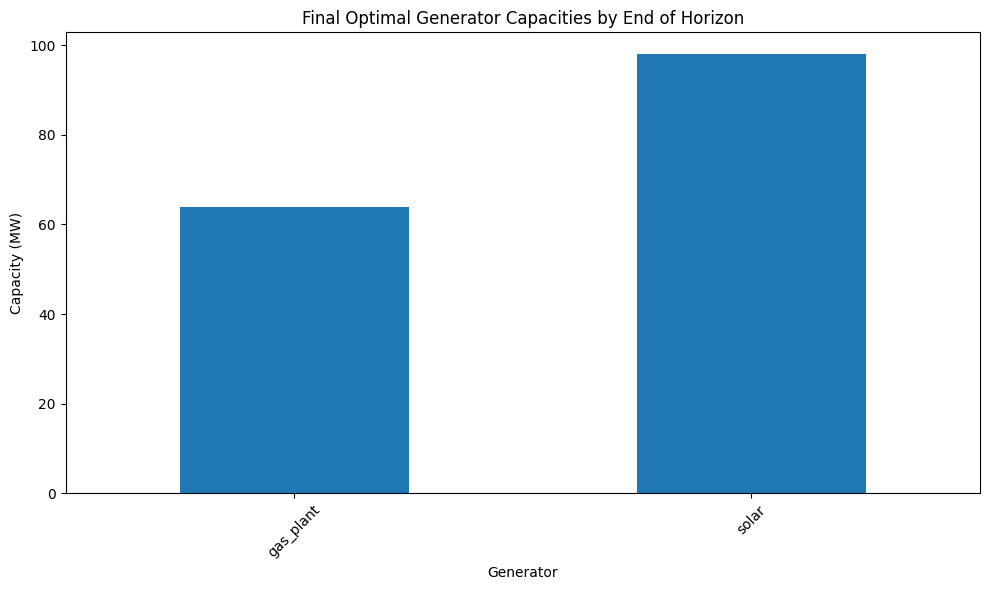

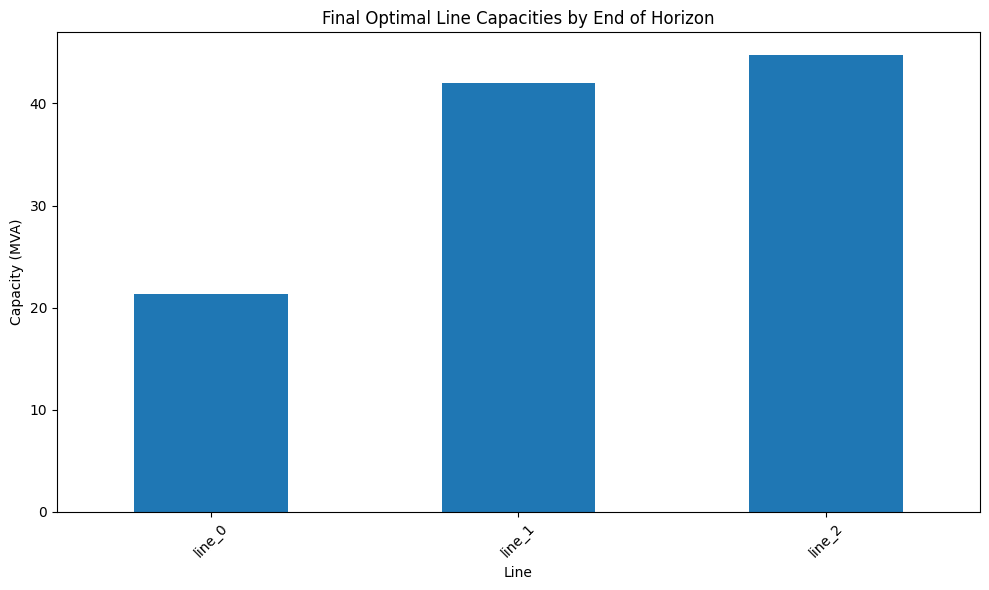


Total System Costs (Objective Value):
457286.67


In [36]:
# Analyze results only if optimization was successful
if status == "ok" and condition == "optimal":
    # Plot capacity expansion over time
    # Note: p_nom_opt shows the TOTAL optimal capacity at the end of the planning horizon (e.g., 2050)
    plt.figure(figsize=(10, 6))
    network.generators.p_nom_opt.plot(kind='bar')
    plt.title('Final Optimal Generator Capacities by End of Horizon')
    plt.xlabel('Generator')
    plt.ylabel('Capacity (MW)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot line capacity expansion
    # Note: s_nom_opt shows the TOTAL optimal capacity at the end of the planning horizon
    plt.figure(figsize=(10, 6))
    network.lines.s_nom_opt.plot(kind='bar')
    plt.title('Final Optimal Line Capacities by End of Horizon')
    plt.xlabel('Line')
    plt.ylabel('Capacity (MVA)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Print system costs
    print("\nTotal System Costs (Objective Value):")
    # This includes annualized investment costs and total operational costs over the horizon
    print(f"{network.objective:.2f}")
else:
    print("Skipping results analysis due to non-optimal solver status.")

## Key Investment Planning Concepts

1. **Investment Periods**
   - Define time periods for investment decisions
   - Can have different constraints for each period
   - Account for time value of money through discounting

2. **Capacity Expansion**
   - Components can be made extendable
   - Set minimum and maximum capacity limits
   - Define capital costs for investment

3. **Global Constraints**
   - Can be period-specific
   - Examples: CO2 limits, renewable share targets
   - Can guide investment decisions

4. **Cost Components**
   - Capital costs for investment
   - Operational costs (marginal costs)
   - Discounted over time

## Next Steps

In the next tutorial, we'll explore storage systems and demand-side management options.